In [1]:
# This script performs analysis on gaze state classification

# Plan: 

# metrics that don't distiguish between remote / collocated

#  - proportion of time looking at other participants
#  - proportion of time transitioning
#  - proportion of time averting
#  - glance duration
#  - glance frequency
#  - transition duration

# metrics that are person dependent

# - proportion of time looking at each other participant
# - frequency of glances at other participants
# - proportion of mutual gaze with other participants
# - length of mutual gazes with other participants
# - frequency of mutual gazes with other participants


In [2]:
import re
import matplotlib.pyplot as plt
from enum import Enum
import os
import statistics
import numpy as np
import get_tcm as tcm
import csv

In [3]:
#define location of data to process

# data_dir="C:/Users/gary4/Documents/repos/Recording-And-Analysis-Plugin/Data/group0"
# data_dir="Z:/Gary/Research/APlausE-MR_MR4_CollaborativeTelepresenceStudy/gazeAnalysis/group0"
# data_dir="Z:/builds/aplause-mr/UNITY_APP/aplause-mr-20240707-studystate-v1/gazeAnalysisv2"
data_dir="C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2"


# find all "gaze_classification_results" files
files = os.listdir(data_dir)
files_to_process = [f for f in files if "gaze_classification_results.csv" in f] 

print("Found " + str(len(files_to_process)) + " files to process")


Found 64 files to process


In [4]:
# define some constants

NUM_PARTICIPANTS = 4


In [5]:
# load or generate trial-condition mapping
df_tcm_l = tcm.get_tcm(np.arange(20), 'APMR-MR4', 'long')

exclude_groups = True #optionally exclude groups
groups_to_drop = [7, 8, 17, 18]
groups_to_keep = [x for x in np.arange(20) if x not in groups_to_drop] #groups to include in evaluation: IDs 0-6, 9-16, 19

df_tcm_l.drop(df_tcm_l[~df_tcm_l.group_ID.isin(groups_to_keep)].index, inplace=True)

df_tcm_l

,group_ID,trial_ID,condition
0,0,0,DIOTIC_VOLUMETRIC
1,0,1,DIOTIC_ABSTRACT
2,0,2,SPATIAL_ABSTRACT
3,0,3,SPATIAL_VOLUMETRIC
4,1,0,DIOTIC_ABSTRACT
...,...,...,...
67,16,3,SPATIAL_VOLUMETRIC
76,19,0,SPATIAL_ABSTRACT
77,19,1,DIOTIC_VOLUMETRIC
78,19,2,SPATIAL_VOLUMETRIC


In [6]:
class GazeState(Enum):
    TRANSITION = 0
    LOCAL = 1
    REMOTE_ADJACENT = 2
    REMOTE_OPPOSITE = 3
    AVERTED = 4
    
# Define colors for each GazeState
gaze_state_colors = {
    GazeState.TRANSITION: 'lightgray',
    GazeState.LOCAL: 'limegreen',
    GazeState.REMOTE_ADJACENT: 'yellow',
    GazeState.REMOTE_OPPOSITE: 'cornflowerblue',
    GazeState.AVERTED: 'black',
}

In [7]:
# define some data structures for reading data

class GazeClassification:

    def __init__(self, desc):
        self.times = []
        self.values = []
        self.intervals = None
        # find participant ID for gazer
        participant_label_ends = [m.end() for m in re.finditer('Participant', desc)]
        self.gazer = int(desc[participant_label_ends[0]])
        
    def add_value(self,time,value):
        self.times.append(time)
        self.values.append(GazeState(value))
        
    def GetGazeStateTotalDurations(self):
        
        state_durations = [0] * len(GazeState)
        
        duration_lists = self.GetGazeStateDurationList()
        
        for i in range(len(GazeState)):
            state_durations[i] = sum(duration_lists[GazeState(i)])
            
        return state_durations
    
    def GetGazeStateDurationList(self):
        
        duration_lists = {state: [] for state in GazeState}

        self.GetIntervals()
    
        for state in GazeState:
            for i in self.intervals[state]:
                duration_lists[state].append(i[1] - i[0])
    
        return duration_lists
    
    def GetIntervals(self):
        if self.intervals is None:
            self.CalculateIntervals()
        return self.intervals
    
    def CalculateIntervals(self):
        
        self.intervals = {state: [] for state in GazeState}

        last_state = self.values[0]
        state_start = self.times[0]
        
        for i in range(1, len(self.times)):
            
            state = self.values[i]
            
            if state != last_state:
                self.intervals[last_state].append( [state_start, self.times[i]] )
                state_start = self.times[i]
            
            last_state = state       
        


In [8]:
# plot intervals to check mutual gaze calculation

def PlotIntervals(all_intervals):

    # Create a figure and subplots
    fig, ax = plt.subplots(len(all_intervals), 1, figsize=(20,9))

    x_axis_lim = max(all_intervals[0][-1][1], all_intervals[1][-1][1])
    
    # Plot each set of intervals on a separate horizontal bar chart
    for i, intervals in enumerate(all_intervals):
        for j, (start, end) in enumerate(intervals):
#             ax[i].barh(j, end - start, left=start, height=0.4)
            ax[i].broken_barh([(start, end - start)], (0, 1))

        ax[i].set_xlim(0, x_axis_lim)  # Set x-axis limit
        ax[i].set_ylim(0, 1)  # Set y-axis limit to fit all bars
        ax[i].set_yticks([])  # Set y-ticks
        ax[i].set_yticklabels([])
        ax[i].set_xlabel('Time')
#         ax[i].set_title(f'Set {i+1}')

    plt.tight_layout()
    plt.show()

In [9]:
# given a set of (4) GazeClassification objects, one from each participant,
# this function calculates intervals during which mutual gaze could be observed

class MutualGazeIntervals:
    def __init__(self, participant_a, participant_b, state):
        self.participant_a = participant_a
        self.participant_b = participant_b
        self.intervals = []
        self.durations = []
        self.gaze_state = state
        
        
def GetGazeStateFromGazerAndTarget(gazer, gaze_target):
    if gazer == gaze_target:
        raise RuntimeError("gazer and target cannot be the same")
    if (gazer + gaze_target) % 2 == 0:
        return GazeState.REMOTE_OPPOSITE
    if int(gazer / 2) == int(gaze_target / 2):
        return GazeState.LOCAL
    
    return GazeState.REMOTE_ADJACENT
        
def GetMutualGazeDurations(participant_gaze_classifications):
    
    if len(participant_gaze_classifications) != NUM_PARTICIPANTS:
        raise RuntimeError("expected gaze classification for each participant")
        
    pairwise_mutual_gaze_intervals = []
    
    for p_a in range(NUM_PARTICIPANTS):
        for p_b in range(p_a + 1, NUM_PARTICIPANTS):
            
            mutual_gaze_state = GetGazeStateFromGazerAndTarget(p_a, p_b)
            pairwise_intervals = MutualGazeIntervals(p_a, p_b, mutual_gaze_state)

            p_a_intervals = participant_gaze_classifications[p_a].GetIntervals()[mutual_gaze_state]
            p_b_intervals = participant_gaze_classifications[p_b].GetIntervals()[mutual_gaze_state]
            
            for i, (start1, end1) in enumerate(p_a_intervals):
                for j, (start2, end2) in enumerate(p_b_intervals):
                    
                    # Check for overlapping intervals
                    if start1 < end2 and start2 < end1:
                        # Overlapping interval
                        overlap_start = max(start1, start2)
                        overlap_end = min(end1, end2)

                        pairwise_intervals.intervals.append((overlap_start, overlap_end))
                        pairwise_intervals.durations.append(overlap_end - overlap_start)
            
            
            pairwise_mutual_gaze_intervals.append(pairwise_intervals)
    

#     plot intervals from two participants and mutual intervals
#     intervals_to_plot = [participant_gaze_classifications[0].GetIntervals()[GazeState.REMOTE_OPPOSITE], \
#                          participant_gaze_classifications[2].GetIntervals()[GazeState.REMOTE_OPPOSITE], \
#                          pairwise_mutual_gaze_intervals[1].intervals]
#     PlotIntervals(intervals_to_plot)
    
    return pairwise_mutual_gaze_intervals
    
    


In [10]:
# data structure for writing data

class GazeAnalysisResult:
    
    def __init__(self, participant_id, group, trial, condition):
        
        self.participant_id = participant_id
        
        self.trial = trial
        self.group = group
        self.condition = condition
        
        split_cond = condition.split('_')
        self.audio_condition = split_cond[0]
        self.avatar_condition =  split_cond[1]
        
        

In [11]:
def ReadData(file_name):
    file_path = data_dir + "/" + file_name
    print("Processing file: " + file_path)

    classification_streams = []

    f = open(file_path, "r")

    while True:
        line = f.readline()
        if not line:
            break

        if line.startswith("AnalysisQuery"):
            classification_streams.append(GazeClassification(line))
            
        elif 'Threshold' in line or line.startswith('Time') or not line.strip():
            pass

        else:
            in_data = line.split(',')

            classification_streams[-1].add_value(float(in_data[0]), int(in_data[1]))

    f.close()
    return classification_streams
    



In [12]:
def MeanOrDefaultValue(lst, default_value):
    if lst:
        return statistics.mean(lst)
    else:
        return default_value

default_data_value = -1
    
def ProcessFile(group, trial, condition):
    
    potential_file_names = [f for f in files_to_process if ("trial" + str(trial) + "_" in f) and ("group" + str(group) + "_" in f)]
    
    if len(potential_file_names) != 1:
        raise RuntimeError("Did not find file for group " + str(group) + " and trial " + str(trial))
    
    file_name = potential_file_names[0]
    
    classification_streams = ReadData(file_name)

    if len(classification_streams) != NUM_PARTICIPANTS:
        raise RuntimeError("Found incorrect number of gaze classification streams")
    
    results = []
    
    # Calculate mutual gaze intervals
    mutual_gaze_results = GetMutualGazeDurations(classification_streams)
    
    for p in range(NUM_PARTICIPANTS):
        result_struct = GazeAnalysisResult(p, group, trial, condition)

#         result_struct.group = group
#         result_struct.trial = trial
#         result_struct.condition = condition
        
        trial_length = classification_streams[p].times[-1]
        
        # get duration for which each state is held
        state_durations = classification_streams[p].GetGazeStateTotalDurations()
        state_duration_list = classification_streams[p].GetGazeStateDurationList()
        
        # - proportion of time looking at each other participant
        result_struct.gaze_local_pc = state_durations[GazeState.LOCAL.value] / trial_length * 100.0
        result_struct.gaze_remote_adjacent_pc = state_durations[GazeState.REMOTE_ADJACENT.value] / trial_length * 100.0
        result_struct.gaze_remote_opposite_pc = state_durations[GazeState.REMOTE_OPPOSITE.value] / trial_length * 100.0
        result_struct.gaze_others_pc = result_struct.gaze_local_pc + result_struct.gaze_remote_adjacent_pc + result_struct.gaze_remote_opposite_pc

        
        
        #  - proportion of time transitioning
        result_struct.gaze_transition_pc = 100.0 * state_durations[GazeState.TRANSITION.value] / trial_length;
        
        #  - proportion of time averting        
        result_struct.gaze_avert_pc = 100.0 * state_durations[GazeState.AVERTED.value] / trial_length;

        # check percentages
        result_struct.pc_all = result_struct.gaze_others_pc + result_struct.gaze_transition_pc + result_struct.gaze_avert_pc
        
        # - transition duration
        result_struct.gaze_transition_mean_duration_sec = MeanOrDefaultValue(state_duration_list[GazeState.TRANSITION], default_data_value)
    
        # - glance duration
        all_glance_durations = state_duration_list[GazeState.LOCAL] \
                                + state_duration_list[GazeState.REMOTE_ADJACENT] \
                                + state_duration_list[GazeState.REMOTE_OPPOSITE]
        result_struct.gaze_glance_mean_duration_sec = MeanOrDefaultValue(all_glance_durations, default_data_value)
        
        #  - glance frequency
        result_struct.glance_per_min = len(all_glance_durations) / trial_length * 60
        
        # - frequency of glances at other participants
        result_struct.glance_local_per_min = len(state_duration_list[GazeState.LOCAL]) / trial_length * 60
        result_struct.glance_remote_adjacent_per_min = len(state_duration_list[GazeState.REMOTE_ADJACENT]) / trial_length * 60
        result_struct.glance_remote_opposite_per_min = len(state_duration_list[GazeState.REMOTE_OPPOSITE]) / trial_length * 60
        
        
        # - proportion of mutual gaze with other participants
        # - length of mutual gazes with other participants
        # - frequency of mutual gazes with other participants
        
        mutual_gaze_results_local = [m for m in mutual_gaze_results if m.gaze_state == GazeState.LOCAL \
                                       and (m.participant_a == p or m.participant_b == p)][0]
        
        result_struct.mutual_gaze_local_pc = sum(mutual_gaze_results_local.durations) / trial_length * 100.0
        result_struct.mutual_gaze_local_mean_duration = MeanOrDefaultValue(mutual_gaze_results_local.durations, default_data_value)
        result_struct.mutual_gaze_local_per_min = len(mutual_gaze_results_local.durations) / trial_length * 60
        
        
        mutual_gaze_results_remote_opp = [m for m in mutual_gaze_results if m.gaze_state == GazeState.REMOTE_OPPOSITE \
                                       and (m.participant_a == p or m.participant_b == p)][0]
        
        result_struct.mutual_gaze_remote_opp_pc = sum(mutual_gaze_results_remote_opp.durations) / trial_length * 100.0
        result_struct.mutual_gaze_remote_opp_mean_duration = MeanOrDefaultValue(mutual_gaze_results_remote_opp.durations, default_data_value)
        result_struct.mutual_gaze_remote_opp_per_min = len(mutual_gaze_results_remote_opp.durations) / trial_length * 60
        
        mutual_gaze_results_remote_adj = [m for m in mutual_gaze_results if m.gaze_state == GazeState.REMOTE_ADJACENT \
                                       and (m.participant_a == p or m.participant_b == p)][0]
        
        result_struct.mutual_gaze_remote_adj_pc = sum(mutual_gaze_results_remote_adj.durations) / trial_length * 100.0
        result_struct.mutual_gaze_remote_adj_mean_duration = MeanOrDefaultValue(mutual_gaze_results_remote_adj.durations, default_data_value)
        result_struct.mutual_gaze_remote_adj_per_min = len(mutual_gaze_results_remote_adj.durations) / trial_length * 60
        
        results.append(result_struct)
    
    
    
    return results, trial_length
            

In [15]:
# do the analysis for all trials 

all_results = []

trial_lengths = []

for index, row in df_tcm_l.iterrows():
    row_results, trial_length = ProcessFile(row['group_ID'], row['trial_ID'],  row['condition'])
    all_results += row_results
    trial_lengths.append(trial_length)


# Convert objects to a list of dictionaries using __dict__
all_results_writable = [res.__dict__ for res in all_results]

out_path = data_dir + "/gaze_classification_analysis_results.csv"

with open(out_path, mode='w', newline='') as file:
    fieldnames = all_results_writable[0].keys()
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()
    writer.writerows(all_results_writable)

Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group0_date20240708_10_42_trial0_experimentcontroller_gaze_classification_results.csv
Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group0_date20240708_11_22_trial1_experimentcontroller_gaze_classification_results.csv
Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group0_date20240708_11_22_trial2_experimentcontroller_gaze_classification_results.csv
Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group0_date20240708_11_22_trial3_experimentcontroller_gaze_classification_results.csv
Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group1_date20240709_10_09_trial0_experimentcontroller_gaze_classification_results.csv
Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group1_date20240709_10_09_trial1_exp

Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group14_date20240722_10_38_trial0_experimentcontroller_gaze_classification_results.csv
Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group14_date20240722_10_38_trial1_experimentcontroller_gaze_classification_results.csv
Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group14_date20240722_10_38_trial2_experimentcontroller_gaze_classification_results.csv
Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group14_date20240722_10_38_trial3_experimentcontroller_gaze_classification_results.csv
Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group15_date20240722_13_49_trial0_experimentcontroller_gaze_classification_results.csv
Processing file: C:/Users/gary4/Documents/Work/BUW/Research/MR4/gazeAnalysisv2/aplausemr_group15_date20240722_13_49_tria

Total trials: 64
Unfinished trials: 7
Mean trial length (s): 336.87894736843265
Mean trial length: 5:36.87894736843265
(SD: 91.23347939852253)


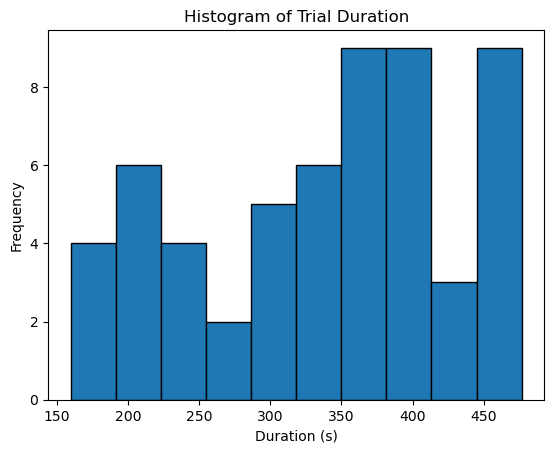

In [26]:
print("Total trials: " + str(len(trial_lengths)))

trials_task_unfinished = len([t for t in trial_lengths if t > (60*8-1)])
print("Unfinished trials: " +  str((trials_task_unfinished)))

finished_trial_lengths = [t for t in trial_lengths if t < (60*8-1)]
mean = statistics.mean(finished_trial_lengths)
print("Mean trial length (s): " + str(mean))

mean_mins = int(mean / 60)
mean_secs = mean - (mean_mins * 60)
print("Mean trial length: " + str(mean_mins) + ":" + str(mean_secs))

print("(SD: " + str(statistics.stdev(finished_trial_lengths)) + ")")

plt.hist(finished_trial_lengths, edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Trial Duration')
plt.xlabel('Duration (s)')
plt.ylabel('Frequency')
plt.show()
    